In [1]:
import os
import os.path
import sys
import json
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader

tf.test.gpu_device_name()
tf.reset_default_graph()

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
class Model:
    def __init__(self, embeddings, BATCH_SIZE, SEQ_LEN, train, beta=4e-6):
        self.batch_size = BATCH_SIZE
        self.seq_len = SEQ_LEN
        self.embeddings = embeddings
        self.train = train

        self.inputs = tf.placeholder(tf.int32, [BATCH_SIZE, SEQ_LEN], name="inputs")
        self.masks = tf.placeholder(tf.float32, [BATCH_SIZE, SEQ_LEN], name="mask")
        self.labels = tf.placeholder(tf.int32, [BATCH_SIZE], name="labels")
        self.train = tf.placeholder(tf.bool, [], name='train')

        x, weights = self.forward()
        loss = self.__call__(x)
        
        self.op = tf.train.RMSPropOptimizer(0.001).minimize(loss)
        self.epoch = tf.Variable(0, dtype=tf.int32, trainable=False, name='epoch')

    def __call__(self, x):
        masks = self.masks
        labels = self.labels
        outputs = tf.reduce_mean(x * tf.expand_dims(masks, -1), 1)
        logits = tf.layers.dense(tf.squeeze(outputs), 2)
        pred = tf.argmax(tf.nn.softmax(logits), -1)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        self.cost = tf.reduce_sum(loss) / self.batch_size
        correct_prediction = tf.equal(tf.cast(pred, tf.int32), labels)
        self.accuracy = tf.reduce_sum(tf.cast(correct_prediction,tf.float32)) / self.batch_size
        
        return loss

In [0]:
class DenseModel(Model):
    def forward(self):
        inputs = self.inputs
        num_layers = 4
        input_size = 300
        num_convs = 256
        conv_size = 2
        x = tf.expand_dims(tf.nn.embedding_lookup(self.embeddings, inputs), -1)
        qrnn = DenseLayer(input_size,conv_size,num_convs,range(num_layers),num_layers, dropout=0.3)
        x = qrnn(x, train=self.train)
        weights = [l.W for l in qrnn.layers] + [l.b for l in qrnn.layers]
        return tf.squeeze(x), weights

In [0]:
class QRNNLayer:
    def __init__(self, input_size, conv_size, hidden_size, layer_id, pool='fo', zoneout=0.0, num_in_channels=1):
        
        self.input_size = input_size
        self.conv_size = conv_size if conv_size%2==0 else conv_size+1
        self.hidden_size = hidden_size
        self.layer_id = layer_id
        self.pool = pool
        self.zoneout = zoneout
        self.num_in_channels = num_in_channels
        init = tf.random_normal_initializer()
        filter_shape = [conv_size, input_size, num_in_channels, hidden_size*(len(pool)+1)]

        with tf.variable_scope('QRNN/conv/'+str(layer_id)):
            self.W = tf.get_variable('W', filter_shape, initializer=init, dtype=tf.float32)
            self.b = tf.get_variable('b', [hidden_size*(len(pool)+1)], initializer=init, dtype=tf.float32)

    def __call__(self, inputs, train=None):
        gates = self.conv(inputs)
        if self.zoneout and self.zoneout > 0.0:
            F = gates[2]
            F = tf.cond(train, lambda: 1-tf.nn.dropout(F, 1-self.zoneout), lambda: F)
            gates[2] = F
        if self.pool == 'f': return self.f_pool(gates)
        elif self.pool == 'fo': return self.fo_pool(gates)
        elif self.pool == 'ifo': return self.ifo_pool(gates)

    def conv(self, inputs):
        padded_inputs = tf.pad(inputs, [[0, 0], [self.conv_size - 1, 0], [0, 0], [0, 0]], "CONSTANT")
        conv = tf.nn.conv2d(padded_inputs, self.W, strides=[1, 1, 1, 1],padding='VALID', name='conv'+str(self.layer_id))
        conv += self.b
        gates = tf.split(conv, (len(self.pool)+1), 3)
        gates[0] = tf.tanh(gates[0])
        for i in range(1, len(gates)):
            gates[i] = tf.sigmoid(gates[i])
        return gates

    def unstack(self, gates, pooling):
        if pooling == 'f': Z, F = gates
        elif pooling == 'fo': Z, F, O = gates
        elif pooling == 'ifo': Z, F, O, I = gates

        Z = tf.unstack(Z, axis=1)
        F = tf.unstack(F, axis=1)
        if pooling == 'f': return Z,F
        O = tf.unstack(O, axis=1)
        if pooling == 'fo': return Z,F,O
        I = tf.unstack(O, axis=1)
        if pooling == 'ifo': return Z,F,O,I

    def fo_pool(self, gates):
        Z, F, O = self.unstack(gates,'fo')
        C = [tf.fill(tf.shape(Z[0]), 0.0)] #tf.zeros(tf.shape(Z[0]), tf.float32) #
        H = []
        for i in range(len(Z)):
            c = tf.multiply(F[i], C[-1]) + tf.multiply(1-F[i], Z[i])
            h = tf.multiply(O[i], c)
            C.append(c)
            H.append(h)
        H = tf.stack(H, axis=1)
        return tf.transpose(H, perm=[0, 1, 3, 2]) 

In [0]:
class DenseLayer:
    def __init__(self, input_size, conv_size, hidden_size, layer_ids, num_layers, zoneout=0.0, dropout=0.0):
        self.layers = []
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.layers = [QRNNLayer(hidden_size, conv_size, hidden_size,layer_ids[i], pool='fo', zoneout=zoneout, num_in_channels=i+1) for i in range(num_layers)]

    def __call__(self, inputs, train=None):
        inputs = tf.layers.dense(tf.transpose(inputs, [0, 1, 3, 2]), self.hidden_size)
        inputs = tf.transpose(inputs, [0, 1, 3, 2])
        for layer in self.layers:
            outputs =  layer(inputs, train=train)
            if self.dropout and self.dropout > 0:
                keep_prob = 1 - self.dropout
                outputs = tf.cond(train, lambda: tf.nn.dropout(outputs, keep_prob), lambda: outputs)
            inputs = tf.concat([inputs, outputs], 3)
        return tf.squeeze(outputs[:, :, :, -1])

In [0]:
def get_embeddings(vocab, path, dim = 300):
    vocab_dict = {word: int(_id) for _id, word in vocab.items()}
    embed_id = path.split('.')[-2]
    if embed_id+'_imdb.json' not in os.listdir('.'):
        embeds = {}
        with open(path, encoding="utf8") as f:
            for line in f:
                split = line.split()
                word = split[0].encode('utf-8').lower()
                vec = split[1:]
                if word in vocab_dict.keys():
                    embeds[vocab_dict[word]] = list(map(float,vec))
        with open(embed_id+'_imdb.json', 'w') as f:
            f.write(json.dumps(embeds))
    else:
        with open(embed_id+'_imdb.json') as f:
            embeds = {int(_id): word for _id, word in json.loads(f.read()).items()}
    embed_list = []
    for i in range(3):
        var = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[dim]), dtype=tf.float32)
        embed_list.append(var)
    for _id, word in vocab.items():
        if int(_id) in embeds.keys(): embed_list.append(tf.constant(embeds[_id], dtype=tf.float32))
        else: embed_list.append(embed_list[2])
    return tf.stack(embed_list, axis=0)

class imdbDataset(Dataset):
    def __init__(self, dataset, seq_len=100):
        self.x = dataset[0]
        self.pad_inputs(seq_len)
        self.get_masks(seq_len)
        self.y = dataset[1]

    def pad_inputs(self, seq_len):
        new_xs = []
        for x in self.x:
            if len(x) > seq_len: x = x[:seq_len]
            elif len(x) < seq_len: x += [0] * (seq_len - len(x))
            assert len(x) == seq_len
            new_xs.append(x)
        self.x = new_xs

    def get_masks(self, seq_len):
        self.masks = []
        for x in self.x:
            mask = [1.0 * (x_i != 0) for x_i in x]
            assert len(mask) == seq_len
            self.masks.append(mask)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.masks[i], self.y[i]

def get_datasets(batch_size=100, num_words=1000, seq_len=100):
    train, test = imdb.load_data(num_words=num_words)
    vocab = imdb.get_word_index()
    vocab = {int(_id): word.encode('utf-8').lower() for word, _id in vocab.items() if _id <= num_words}
    train = imdbDataset(train, seq_len=seq_len)
    n = int(len(test[0])/2)
    val = imdbDataset((test[0][0:n], test[1][0:n]), seq_len=seq_len)
    test = imdbDataset((test[0][n:], test[1][n:]), seq_len=seq_len)
    if os.path.isfile('./glove.6B.300d.txt')==False:
            !wget http://nlp.stanford.edu/data/glove.6B.zip
            !unzip glove*.zip
    return (DataLoader(train, batch_size), DataLoader(val, batch_size), DataLoader(test, batch_size), vocab)

In [0]:
def run(model, sess, dataset, train=False):
    mean_accuracy = 0.0
    mean_loss = 0.0
    for x, masks, y in dataset:
        input_feed = {
            model.inputs: np.array([i.numpy() for i in x]).T,
            model.masks: np.array([i.numpy() for i in masks]).T,
            model.labels: np.array([i.numpy() for i in y]).T,
            model.train: train
        }

        if train:
            output_feed = [model.cost, model.accuracy, model.op]
            loss, accuracy, _ = sess.run(output_feed, input_feed)
        else:
            output_feed = [model.cost, model.accuracy]
            loss, accuracy = sess.run(output_feed, input_feed)
        mean_loss += loss
        mean_accuracy += accuracy

    mean_loss /= len(dataset)
    mean_accuracy /= len(dataset)
    return mean_loss, mean_accuracy

In [0]:
tf.reset_default_graph()
NUM_EPOCHS = 10
BATCH_SIZE = 25
SEQ_LEN = 400
VOCAB_SIZE = 68379

trainset, valset, testset, vocab = get_datasets(BATCH_SIZE,VOCAB_SIZE,SEQ_LEN)
embeddings = get_embeddings(vocab, './glove.6B.300d.txt')
model = DenseModel(embeddings, BATCH_SIZE, SEQ_LEN, VOCAB_SIZE)
saver = tf.train.Saver()

In [21]:
tr_loss = []
tr_acc = []
vl_loss = []
vl_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = model.epoch.eval()
    for i in range(epoch, NUM_EPOCHS):
        train_loss, train_acc = run(model, sess, trainset, train=True)
        tr_acc.append(train_acc)
        tr_loss.append(train_loss)
        val_loss, val_acc = run(model, sess, valset, train=True)
        vl_acc.append(val_acc)
        vl_loss.append(val_loss)
        print ('epoch: ', i, 'train loss: ', train_loss, 'train acc: ', train_acc, 'val loss: ', val_loss, 'val acc: ', val_acc)
        sess.run(tf.assign(model.epoch, i+1))
    saver.save(sess, 'checkpoints',write_state=True)

epoch:  0 train loss:  0.6917249321937561 train acc:  0.5193600255250931 val loss:  0.6876569604873657 val acc:  0.553840024471283
epoch:  1 train loss:  0.6810762572288513 train acc:  0.5745200264453888 val loss:  0.6762374711036682 val acc:  0.5843200349807739
epoch:  2 train loss:  0.6683268702030182 train acc:  0.5990400338172912 val loss:  0.6634389400482178 val acc:  0.6104800295829773
epoch:  3 train loss:  0.6552047657966614 train acc:  0.6248800337314606 val loss:  0.6513497447967529 val acc:  0.6296000289916992
epoch:  4 train loss:  0.6438039743900299 train acc:  0.6402800273895264 val loss:  0.6394701313972473 val acc:  0.6448800301551819
epoch:  5 train loss:  0.6339041721820832 train acc:  0.6533600306510925 val loss:  0.6291228652000427 val acc:  0.6598400354385376
epoch:  6 train loss:  0.6248650193214417 train acc:  0.6622400307655334 val loss:  0.62214608669281 val acc:  0.6696800303459167
epoch:  7 train loss:  0.6158512985706329 train acc:  0.6716000306606292 val lo

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.get_checkpoint_state('').model_checkpoint_path)
    test_loss, test_acc = run(model, sess, testset)
    print ('test loss: ', test_loss, 'test acc: ', test_acc)

INFO:tensorflow:Restoring parameters from checkpoints
test loss:  0.55588800907135 test acc:  0.7230400323867798


In [0]:
def plot_performance(train, val, label):
    plt.plot(train)
    plt.plot(val)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

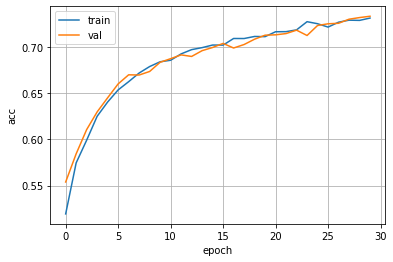

In [24]:
import matplotlib.pyplot as plt
plot_performance(tr_acc, vl_acc, 'acc')

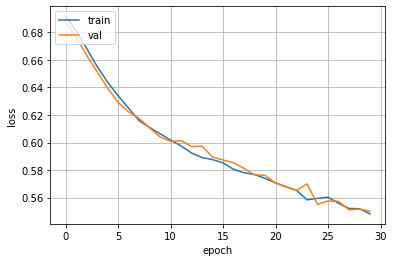

In [25]:
plot_performance(tr_loss, vl_loss, 'loss')